In [1]:
import nltk
import scipy
import pickle
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import utils
from gensim.models import Doc2Vec
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

np.random.seed(42)
pd.options.display.max_colwidth = 2000
pd.options.display.max_rows = 400

In [2]:
import json
from bs4 import BeautifulSoup
import re


def clean_text(raw_text: str) -> str:
    if raw_text is None:
        return ''

    soup = BeautifulSoup(raw_text, features="html.parser")
    raw_text = soup.get_text()
    raw_text = raw_text.replace('\n', ' ').replace('\xa0', ' ')
    return raw_text


def read_json_as_df(path: str) -> pd.DataFrame:
    json_data = []

    with open(path, 'r', encoding='utf-8') as file:

        for line in file:
            data = json.loads(line)
            json_data.append([clean_text(data['post'].get('body', None)),
                              data['priority']])

    df = pd.DataFrame(data=json_data, columns=('text', 'priority'))

    return df

def read_json_text(path: str, tag: str) -> list:
    json_data = []

    with open(path, 'r', encoding='utf-8') as file:

        for line in file:
            data = json.loads(line)
            json_data.append(clean_text(data.get(tag, None)))

    return json_data

In [3]:
from sklearn.metrics import classification_report, f1_score


def print_results(true_labels, predictions):
    
    print('\n\033[1m-----------Full Classification Report-----------\033[0m\n')
    print(classification_report(true_labels, predictions))
    
    
    print("\n\033[1m------OFFICIAL - ignoring 'green' priority------\033[0m\n")
    print('\tMacro avgd f1 score: ', f1_score(true_labels, predictions, labels=['escalate', 'red', 'amber'], average='macro'))
    
    
    print("\n\033[1m----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----\033[0m\n")
    def map_flagged(label):
        if label in ['escalate', 'red', 'amber']:
            return 'flagged'
        elif label == 'green':
            return 'green'

    flagged_ytest = list(map(map_flagged, true_labels))
    flagged_predictions = list(map(map_flagged, predictions))

    print(classification_report(flagged_ytest, flagged_predictions))
    
    print("\n\033[1m----URGENT - 'red + escalate' as urgent vs 'amber + green' as non_urgent-----\033[0m\n")
    def map_urgent(label):
        if label in ['escalate', 'red']:
            return 'urgent'
        elif label in ['green', 'amber']:
            return 'non-urgent'

    urgent_ytest = list(map(map_urgent, true_labels))
    urgent_predictions = list(map(map_urgent, predictions))

    print(classification_report(urgent_ytest, urgent_predictions))


In [4]:
sentences = read_json_text('../Data/message.json', 'body')

c:\users\vedant\pycharmprojects\researchproject32934\venv\lib\site-packages\bs4\__init__.py:312: UserWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)
c:\users\vedant\pycharmprojects\researchproject32934\venv\lib\site-packages\bs4\__init__.py:312: UserWarning: "D:" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)
c:\users\vedant\pycharmprojects\researchproject32934\venv\lib\site-packages\bs4\__init__.py:312: UserWarning: "............." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)
c:\users\vedant\pycharmprojects\researchproject32934\venv\lib\site-packages\bs4\__init__.py:312: UserWarning: "..." looks like a filename, not mark

In [5]:
train_df = read_json_as_df('../Data/clpsych16-train.json')
test_df = read_json_as_df('../Data/clpsych16-test.json')

In [6]:
# train_df.text = train_df.text.str.strip()
train_df = train_df[train_df.text != '']

# test_df.text = test_df.text.str.strip()
test_df = test_df[test_df.text != '']

In [7]:
#-----------------------------------------------------------------
def tokenize(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    vectors = [(model.infer_vector(doc.words, steps=30)) for doc in sents]
    return vectors

#-----------------------------------------------------------------

In [8]:
full_train = [TaggedDocument(words=tokenize(sent), tags=[i]) for i,sent in tqdm(enumerate(sentences))]

321673it [03:10, 1689.71it/s]


In [9]:
train_tagged = train_df.apply(
    lambda r: TaggedDocument(words=tokenize(r.text), 
                             tags=[r.priority]), axis=1)
test_tagged = test_df.apply(
    lambda r: TaggedDocument(words=tokenize(r.text), 
                             tags=[r.priority]), axis=1)

In [10]:
%%time

model = Doc2Vec(documents=full_train, 
                dm=0, 
                workers=10, 
                min_count=5,
                epochs=30,
                vector_size=64,
                window=12
               )

Wall time: 9min 5s


In [11]:
ytrain, xtrain = train_df.priority, vec_for_learning(model, train_tagged)
ytest, xtest = test_df.priority, vec_for_learning(model, test_tagged) 

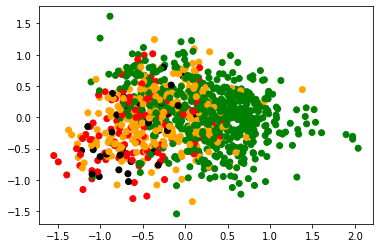

In [12]:
pca = PCA(n_components=2).fit(xtrain)

features_2d = pca.transform(xtrain)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

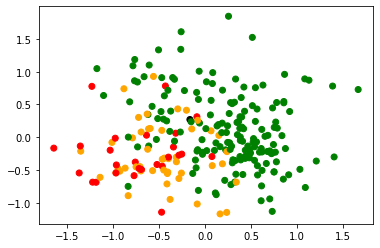

In [13]:
pca = PCA(n_components=2).fit(xtest)

features_2d = pca.transform(xtest)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=test_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

In [18]:
%%time

params = {'C': scipy.stats.expon(scale=10), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf'], 'class_weight':['balanced']}

clf = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         n_jobs=10,
                         scoring='f1_macro',
                         cv=5,
                         n_iter=100,
                         verbose=5)

# params = [
#     {'C': [0.1, 1.0, 10], 'gamma': [0.01, 0.1, 1.0], 'kernel': ['rbf'], 'class_weight':['balanced']},
# ]

# clf = GridSearchCV(estimator=SVC(),
#                          param_grid=params,
#                          n_jobs=10,
#                          scoring='f1_macro',
#                          cv=5)

svc_searched_clf = clf.fit(xtrain, ytrain)


print('Best Params:', svc_searched_clf.best_params_, '\n')
print('Best macro avg F1 score:', svc_searched_clf.best_score_, '\n')
print(svc_searched_clf.best_estimator_, '\n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   13.0s


Best Params: {'C': 1.791260450716679, 'class_weight': 'balanced', 'gamma': 0.05773344695893047, 'kernel': 'rbf'} 

Best macro avg F1 score: 0.5301663733449956 

SVC(C=1.791260450716679, class_weight='balanced', gamma=0.05773344695893047) 

Wall time: 15 s


[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   14.8s finished


In [19]:
predicted_priority = svc_searched_clf.predict(xtest)    
print_results(ytest, predicted_priority)


-----------Full Classification Report-----------

              precision    recall  f1-score   support

       amber       0.54      0.57      0.56        47
    escalate       0.00      0.00      0.00         1
       green       0.95      0.88      0.91       165
         red       0.46      0.48      0.47        27

    accuracy                           0.77       240
   macro avg       0.49      0.48      0.49       240
weighted avg       0.81      0.77      0.79       240


------OFFICIAL - ignoring 'green' priority------

	Macro avgd f1 score:  0.3431427678850359

----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----

              precision    recall  f1-score   support

     flagged       0.77      0.91      0.83        75
       green       0.95      0.88      0.91       165

    accuracy                           0.89       240
   macro avg       0.86      0.89      0.87       240
weighted avg       0.90      0.89      0.89       240


----URGENT - 'red + escalate

In [16]:
test_df['prediction'] = predicted_priority

In [17]:
test_df[test_df.priority != test_df.prediction]

,text,priority,prediction
4,@Sophie-RO this is kinda a side note but how's the SuperMe thing goin?,green,amber
17,I don't have Skype! I'm not SUPER keen anyway. I'm just interested.Take care and keep doing what you're doing cause it's great!,green,amber
18,"stonepixie: GRRRR!!!! One minute it is 8:52 and then the next, it is 11:09. Pretty bummed that I missed the chat tonight. I even reminded people and Sophie even sent me an e-mail. I guess what is done, is done. Only thing I can do is read over it instead.",green,amber
28,"@N1ghtW1ng I'd adapt it, I couldn't just sent it as is...",amber,green
34,Upset. I got the reply from KHL about my complaint. All they did was make excuses for themselves. No help at all 😔,red,amber
36,"@Aria thank you it sure does gang up on you, friends and family are aware but Its so hard to understand the extent of it your not experiencing it yourself so sometimes I think it seems people downsize the problem by thinking its just me being pedantic..if only",amber,green
40,"@thedoctor I should definately seek a helpline and go back to seeing a psych, it's time and money too though. There's not enough hours in a day. Im too old for kids line and head space but I think there are some other places like beyond blue.My 4 year old is under so many specialists that I feel like im going to lose my job running around with him so i come last if at all. But its at breaking point and something has got to give so I really need a rocket up my butt and somehow snap out of this! Its ruining my life!",amber,red
43,What I don't do which is something I should do is see the rewards in helping myself and the good things that can happen. Motivation is key in helping yourself and I really don't have that much. I try doing small things first like eating breakfast (which I don't do very often and I should do now ) which issomething everyone should do. When I move up to doing homework that's hard. I can tell myself all the good things that can come out of it but I see the homework in most subjects useless. The thing that gets me is that one negative thing that ruins all the positives. As you said @Troy with the flossing I would start by giving it a 'try'. By try I mean doing it once. And then 'trying' it the next day and the day after at the same time in the morning/afternoon until it kinda feels normal and it just becomes a habit.,green,amber
45,"@Blue_dude I'm going through the same thing, thing is I'm 100% extroverted and no one seems to have just the slightest interest of beIng my friend. I just spend hours in bed asking Google what's wrong with me and why don't people want to be my friend. I don't go to school anymore and rarely do my homework. Just know that your not alone, and I am sending you love and support, cause this is hard to battle (:",green,escalate
48,That sucks that they didn't properly address your complaint J. Right now I am pissed off that I can't figure out wtf I am. Like I obviously don't give enough shits to make a choice. Such a fucking fail.,red,amber
